In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score
import pickle

In [16]:
# Load dataset
df = pd.read_csv('Twitter Sentiments.csv') 

In [17]:
# Basic dataset info
print("Dataset shape:", df.shape)
print("Label distribution:")
print(df['label'].value_counts())

Dataset shape: (31962, 3)
Label distribution:
label
0    29720
1     2242
Name: count, dtype: int64


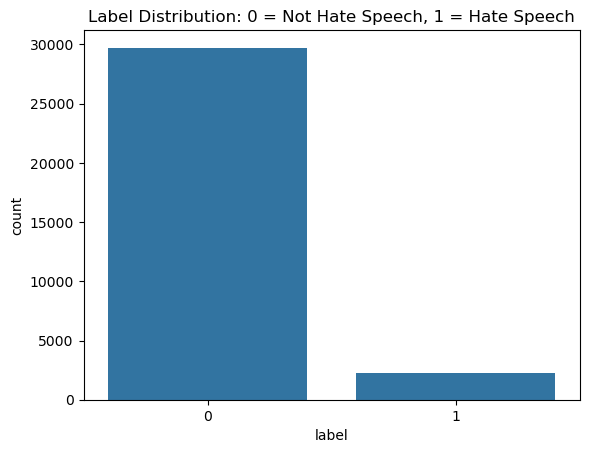

In [18]:
# Visualize label distribution
sns.countplot(x='label', data=df)
plt.title('Label Distribution: 0 = Not Hate Speech, 1 = Hate Speech')
plt.show()


In [19]:
# WordCloud for different classes
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

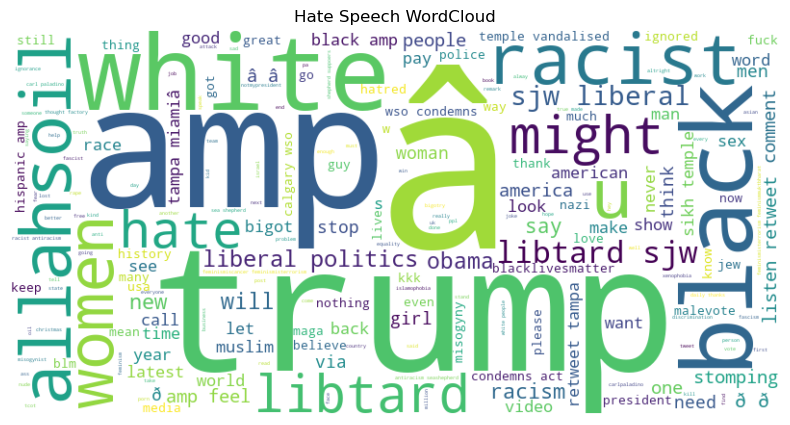

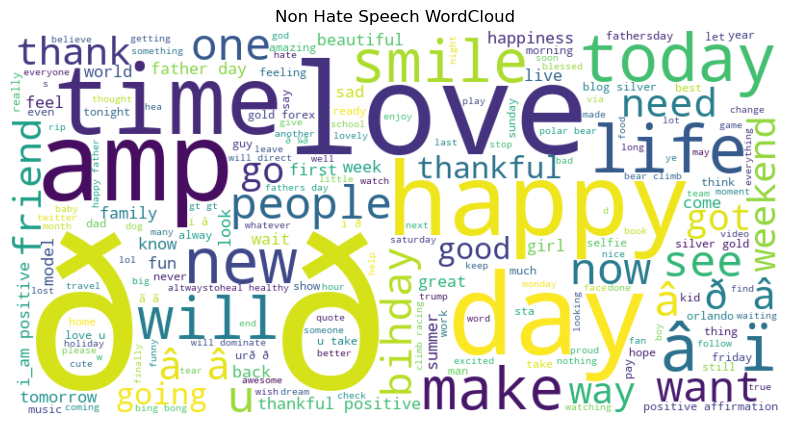

In [20]:
# Preclean tweets for wordcloud (remove handles)
df['tweet_no_handles'] = df['tweet'].apply(lambda x: re.sub(r'@\w+', '', x))

plot_wordcloud(df[df['label']==1]['tweet_no_handles'], 'Hate Speech WordCloud')
plot_wordcloud(df[df['label']==0]['tweet_no_handles'], 'Non Hate Speech WordCloud')

# Improved minimal preprocessing (to preserve words better)
def preprocess_tweet(text):
    text = re.sub(r'@\w+', '', text)         # Remove twitter handles
    text = re.sub(r'http\S+', '', text)      # Remove URLs
    text = text.lower()                       # Lowercase
    return text.strip()

df['clean_tweet'] = df['tweet'].apply(preprocess_tweet)

In [21]:
# Feature extraction using TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_tweet'])
y = df['label']

In [22]:
# Train-test split preserving label distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [23]:
# Train Logistic Regression with class balancing
model = LogisticRegression(max_iter=300, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=300, random_state=42)

In [24]:
# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8643473908146665
F1 Score: 0.4342379958246347
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7430
           1       0.31      0.74      0.43       561

    accuracy                           0.86      7991
   macro avg       0.64      0.81      0.68      7991
weighted avg       0.93      0.86      0.89      7991



In [25]:
# Save model and vectorizer for deployment
with open('best_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [26]:
# Prediction function
def predict_tweet(tweet_text):
    tweet_text_clean = preprocess_tweet(tweet_text)
    vect = vectorizer.transform([tweet_text_clean])
    prediction = model.predict(vect)[0]
    labels = {0: "Not Hate Speech", 1: "Hate Speech"}
    return labels[prediction]

In [27]:
# Test prediction
print(predict_tweet("You are stupid"))

Hate Speech
